In [2]:
!pip install --upgrade pip
!pip install datasets transformers torch torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib

In [3]:
from transformers import ViTFeatureExtractor
from transformers import TrainingArguments
from transformers import ViTForImageClassification
import torch
import numpy as np
from datasets import load_dataset

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='mps:0')


In [5]:
def load_data():
    d_types = ['test']
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'mnist',
            split=d,
        ))
    return datasets

# 90% of dataset for test and 10% for training
dataset = load_data()[0].map(lambda x: {'image': torch.tensor(np.repeat(np.array(x['image'])[:, :, np.newaxis], 3, axis=2)), 'label': x['label']})



Found cached dataset mnist (/Users/tommyluu/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
Loading cached processed dataset at /Users/tommyluu/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332/cache-4b906212edbe8379.arrow


In [6]:
split = dataset.train_test_split(test_size=0.9)
dataset_train = split['train']
dataset_test = split['test']
dataset_train

Dataset({
    features: ['image', 'label'],
    num_rows: 1000
})

In [7]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label'].names
num_classes, labels

(10, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [8]:
dataset_train['image'][1].size

(28, 28)

In [9]:
# import feature extraction model
model_id = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
).to(device)

/Users/tommyluu/Documents/projects/TDT05-Project-23/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassi

In [10]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)



In [11]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


/var/folders/l9/h_b80cd93jxgk255znsvsxn40000gn/T/ipykernel_6061/1389652664.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
from transformers import Trainer

# training the model
training_args = TrainingArguments(
  output_dir="./vit_model2",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=2,
  save_steps=30,
  eval_steps=30,
  logging_steps=5,
  learning_rate=2e-4,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

train_results = trainer.train(resume_from_checkpoint=False)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer statea
trainer.save_state()







                                              
                                              

  8%|▊         | 5/64 [02:01<05:00,  5.10s/it]


{'loss': 1.9379, 'learning_rate': 0.000184375, 'epoch': 0.16}







                                              
                                              

  8%|▊         | 5/64 [02:26<05:00,  5.10s/it] 


{'loss': 1.6027, 'learning_rate': 0.00016875, 'epoch': 0.31}







                                              
                                              

  8%|▊         | 5/64 [02:52<05:00,  5.10s/it] 


{'loss': 1.2134, 'learning_rate': 0.000153125, 'epoch': 0.47}







                                              
                                              

  8%|▊         | 5/64 [03:17<05:00,  5.10s/it] 


{'loss': 0.922, 'learning_rate': 0.0001375, 'epoch': 0.62}







                                              
                                              

  8%|▊         | 5/64 [03:42<05:00,  5.10s/it] 


{'loss': 0.7344, 'learning_rate': 0.00012187500000000001, 'epoch': 0.78}







                                              
                                              

  8%|▊         | 5/64 [04:08<05:00,  5.10s/it] 


{'loss': 0.5845, 'learning_rate': 0.00010625000000000001, 'epoch': 0.94}


In [ ]:
# evaluate with validation
# metrics = trainer.evaluate(prepared_test)
# trainer.log_metrics("eval", metrics)
# trainer.save_metrics("eval", metrics)


100%|██████████| 146/146 [01:12<00:00,  2.02it/s]

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9811
  eval_loss               =     0.0658
  eval_runtime            = 0:01:13.01
  eval_samples_per_second =     15.955
  eval_steps_per_second   =      1.999


Text(0.5, 1.0, 'ViT: Loss over train steps')

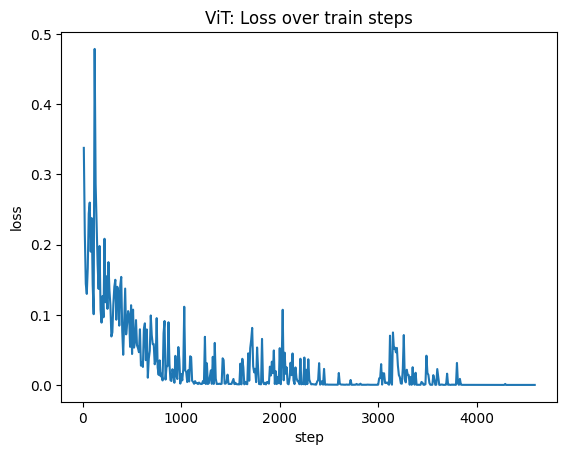

In [ ]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ViT: Loss over train steps')


In [ ]:
# fine tuned model
# import our fine-tuned model
model_name_or_path = './vit_model'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)


/Users/tommyluu/Documents/projects/TDT05-Project-23/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# test on patients with pneumonia
a = [m for m in dataset_valid] #if m['labels'] == 0]

def predict(image):
    inputs = feature_extractor_finetuned(image["image"], return_tensors="pt")
    # extract the actual label of the first image of the testing dataset
    actual_label = image["labels"]

    with torch.no_grad():
        logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    if predicted_label == actual_label:
        return True
    else:
        return False


In [ ]:
count = 0
for img in a:
    if predict(img):
        count += 1
print(f"Accuracy: {count/len(a)}")

Accuracy: 0.9811158798283262
